## Revcode Experiment

#### Aim:- 
    To perform sentiment analysis on IITP Product Reviews dataset with and without Revcode encoding to see if the conversion of native script to english by using Revcode is beneficial in an NLP task.

#### List of parameters considered for this experiment:-
    Encoder - Revcode
    Preprocessing - Normalization
    Vectorizer - BOW(Bag of words), TFIDF (Term frequency inverse document frequency)
    Model - Logistic Regression, SVM(Support Vector Machine)
    Tokenizer - Space separated words

#### Download "IITP Movie Reviews Sentiment" and "IITP Product Reviews" datasets from 
https://indicnlp.ai4bharat.org/indic-glue/



In [65]:
#!pip3 install hurry.filesize
import os
import pandas as pd
from tqdm import tqdm
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from revcode import revcode_conversion as rc
import codecs
from indic_normalization import get_indic_normalized
import pickle
from datetime import datetime
from hurry.filesize import size


train_path = os.path.join(os.getcwd(),"iitp-product-reviews/hi/hi-train.csv")
valid_path = os.path.join(os.getcwd(),"iitp-product-reviews/hi/hi-valid.csv")
test_path = os.path.join(os.getcwd(),"iitp-product-reviews/hi/hi-test.csv")

### 1. Exploratory Data Analysis

In [66]:
df = pd.read_csv(train_path)
df_valid = pd.read_csv(valid_path)
df_test = pd.read_csv(test_path)

#dropping empty rows if any
df = df.dropna(subset=['Text','Label'])
df_valid = df_valid.dropna(subset=['Text','Label'])
df_test = df_test.dropna(subset=['Text','Label'])

#Appending validation dataset to train dataset
df = df.append(df_valid)

print(df.shape)
print(df_test.shape)

print("Here 0 represents negative, 1 represents neutral and 2 represents positive sentence")
df.head()

(4705, 2)
(523, 2)
Here 0 represents negative, 1 represents neutral and 2 represents positive sentence


,Label,Text
0,negative,एंडराॅयड के मामले में यह थोड़ा पीछे है ।
1,neutral,यह एस्पेक्ट रेशो का ईश्यू है और हम आशा करते है...
2,positive,लेकिन इस तरह के एक मॉडल के एक घर कंप्यूटर के ल...
3,positive,गिर वन राष्ट्रीय उद्यान बाघ संरक्षित क्षेत्र ह...
4,neutral,"और हां , इस फिल्म में हर किरदार भारद्वाज को भर..."


In [67]:
# Product Scores
fig = px.histogram(df, x="Label")
fig.update_traces(marker_color="turquoise",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Sentiment distribution')
fig.show()

### 2. Data Preprocessing

In [71]:
#Train test split of data
def train_test_split(df,df_test):
    
    x_train = df["Text"] 
    x_test = df_test["Text"]
    y_train = df["Label"]
    y_test = df_test["Label"]
    
    print(f"Size of train set is {x_train.shape}")
    print(f"Size of test set is {x_test.shape}")

    return x_train, x_test, y_train, y_test


def convert_to_revcode(df,df_test,lang='hi'):
    
    print("Revcode conversion started")
    for i,row in tqdm(df.iterrows()):
        rev_text = rc.to_revcode(row['Text'], lang)
        df.loc[i,'Text'] = rev_text

    for i,row in tqdm(df_test.iterrows()):
        rev_text = rc.to_revcode(row['Text'], lang)
        df_test.loc[i,'Text'] = rev_text

    #print(df.head())
    
    return df, df_test

def normalize_dataset(input_df):
    
    df_normalized = input_df.copy()
    normalized_dict = {}
    total_unique_words = []

    for i,row in tqdm(input_df.iterrows()):
        norm_text = get_indic_normalized(row['Text'])
        df_normalized.loc[i,'Text'] = norm_text

        #find words which are replaced with normalization
        norm_text = norm_text.split()
        org_text = row["Text"].split()
        for i,word in enumerate(org_text):
            total_unique_words.append(word)
            if norm_text[i] != word:
                normalized_dict[org_text[i]] = norm_text[i]
    
    print(f"Total number of unique words in corpus {len(set(total_unique_words))}")
    print(f"Total number of normalized replacements {len(normalized_dict.keys())}")
    print(f"percentage of normalized words {len(normalized_dict.keys())/len(set(total_unique_words))}")
    #print(df_normalized.head())
    
    return df_normalized
    
def BOW_vectorization(x_train, x_test):
    vectorizer = CountVectorizer()
    train_bow = vectorizer.fit_transform(x_train)
    test_bow = vectorizer.transform(x_test)
    
    return train_bow, test_bow

    
def TFIDF_vectorization(x_train, x_test):
    vectorizer = TfidfVectorizer()
    train_tfidf = vectorizer.fit_transform(x_train)
    test_tfidf = vectorizer.transform(x_test)
    
    return train_tfidf, test_tfidf

def grid_search(algo,parameters,x_train,y_train):
    
    clf = GridSearchCV(algo, parameters, cv=3, n_jobs=-1)
    clf.fit(x_train, y_train)
    GridSearchCV(estimator=algo,param_grid=parameters)
    
    return clf

def train_test(x_train, y_train, x_test, y_test, model):
    if model == "LR":
        algo = LogisticRegression()
        parameters = {'penalty':('l1', 'l2', 'elasticnet'), 'C':[1, 0.5, 0.25]}
        best_clf = grid_search(algo,parameters,x_train, y_train)
        clf = LogisticRegression(C=best_clf.best_params_['C'], penalty=best_clf.best_params_['penalty'])
        
    else:
        algo = svm.SVC()
        parameters = {'kernel':('linear', 'rbf'), 'C':[1, 2]}
        best_clf = grid_search(algo,parameters,x_train, y_train)
        clf = svm.SVC(C=best_clf.best_params_['C'], kernel=best_clf.best_params_['kernel'])
        
    #Train model
    print("best parameters:",best_clf.best_params_)
    print("best scores:",best_clf.best_score_)

    clf.fit(x_train, y_train)
    train_predict = clf.predict(x_train) 
    test_predict = clf.predict(x_test)
    
    #Show confusion matrix
    plot_confusion_matrix(clf, x_test, y_test)  
    print("Confusion matrix")
    plt.show()
    
    #show scores
    print(f"Scores of {model} model on Test set")
    print(classification_report(test_predict,y_test))
    
    # Save the trained model as a pickle string.
    timestamp = datetime.now()
    save_path = os.path.join(os.getcwd(),f"model-{timestamp}")
    with open(save_path, 'wb') as f:
        pickle.dump(clf, f)

    print(f"model saved at {f'model-{timestamp}'}")
    
    #Inferance and latency
    # Load the pickled model
    with open(save_path, 'rb') as f:
        model_from_pickle = pickle.load(f)

    model_size = size(os.path.getsize(save_path))
    print(f"Size of model is {model_size}")

    timestamp_1 = datetime.now()
    # Use the loaded pickled model to make predictions
    model_from_pickle.predict(x_test[0])
    timestamp_2 = datetime.now()

    time_diff = timestamp_2-timestamp_1
    print(f"Time taken for single inferance {time_diff}")
    
    return clf


### 3. Model Training and Testing 

In [72]:
def perform_revcode_exp(df, df_test, lang='hi', revcode=False, normalization=False, vectorization="BOW", model="LR"):
    #check vectorization option
    vectorization = vectorization.upper()
    if vectorization not in ["BOW","TFIDF"]:
        print(f"Error, vectorization choice {vectorization} is not available")
        print("Defaulting to BOW vectoriaztion")
        vectorization = "BOW"
        
    #check model option
    model = model.upper()
    if model not in ["LR","SVM"]:
        print(f"Error, model choice {model} is not available")
        print("Defaulting to LR vectoriaztion")
        model = "LR"
       
    #Normalize
    if normalization == True:
        df = normalize_dataset(df)
        df_test = normalize_dataset(df_test)
        
    #Revcode
    if revcode == True:
        df,df_test = convert_to_revcode(df,df_test,lang)
        
    #split dataset
    x_train, x_test, y_train, y_test = train_test_split(df,df_test)
    
    #vectorize dataset
    if vectorization == "BOW":
        x_train, x_test = BOW_vectorization(x_train, x_test)
    else:
        x_train, x_test = TFIDF_vectorization(x_train, x_test)
    
    #train and test model
    clf = train_test(x_train, y_train, x_test, y_test, model)
    
    
    return "Pipeline Completed"
    

4705it [00:03, 1337.97it/s]
148it [00:00, 1469.05it/s]

Total number of unique words in corpus 9662
Total number of normalized replacements 370
percentage of normalized words 0.03829434899606707


523it [00:00, 1402.01it/s]
74it [00:00, 729.10it/s]

Total number of unique words in corpus 2583
Total number of normalized replacements 72
percentage of normalized words 0.027874564459930314
Revcode conversion started


4705it [00:05, 798.25it/s]
523it [00:00, 792.89it/s]


Size of train set is (4705,)
Size of test set is (523,)
best parameters: {'C': 1, 'kernel': 'linear'}
best scores: 0.6289154125640058
Confusion matrix


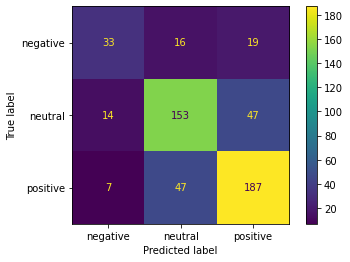

Scores of SVM model on Test set
              precision    recall  f1-score   support

    negative       0.49      0.61      0.54        54
     neutral       0.71      0.71      0.71       216
    positive       0.78      0.74      0.76       253

    accuracy                           0.71       523
   macro avg       0.66      0.69      0.67       523
weighted avg       0.72      0.71      0.72       523

model saved at model-2021-08-03 13:02:38.155105
Size of model is 879K
Time taken for single inferance 0:00:00.001916


'Pipeline Completed'

In [73]:
perform_revcode_exp(df, df_test, lang='hi', revcode=True, normalization=True, vectorization="TFIDF", model="SVM")

## Results

In [240]:
from prettytable import PrettyTable

# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Data Type", "Vectorization", "Model","Accuracy"])
  
# Add rows
myTable.add_row(["Devnagiri", "BOW", "SVM", "67 %"])
myTable.add_row(["Devnagiri", "TFIDF", "SVM", "65 %"])
myTable.add_row(["Devnagiri", "BOW", "LR", "66 %"])
myTable.add_row(["Devnagiri", "TFIDF", "LR", "63 %"])
myTable.add_row(["Revcode", "BOW", "SVM", "69 %"])
myTable.add_row(["Revcode", "TFIDF", "SVM", "70 %"])
myTable.add_row(["Revcode", "BOW", "LR", "69 %"])
myTable.add_row(["Revcode", "TFIDF", "LR", "68 %"])
myTable.add_row(["Normalized", "BOW", "SVM", "65 %"])
myTable.add_row(["Normalized", "TFIDF", "SVM", "64 %"])
myTable.add_row(["Normalized", "BOW", "LR", "64 %"])
myTable.add_row(["Normalized", "TFIDF", "LR", "63 %"])
myTable.add_row(["Normalized + Revcode", "BOW", "SVM", "69 %"])
myTable.add_row(["Normalized + Revcode", "TFIDF", "SVM", "71 %"])
myTable.add_row(["Normalized + Revcode", "BOW", "LR", "69 %"])
myTable.add_row(["Normalized + Revcode", "TFIDF", "LR", "68 %"])
  
print(myTable)

+----------------------+---------------+-------+----------+
|      Data Type       | Vectorization | Model | Accuracy |
+----------------------+---------------+-------+----------+
|      Devnagiri       |      BOW      |  SVM  |   67 %   |
|      Devnagiri       |     TFIDF     |  SVM  |   65 %   |
|      Devnagiri       |      BOW      |   LR  |   66 %   |
|      Devnagiri       |     TFIDF     |   LR  |   63 %   |
|       Revcode        |      BOW      |  SVM  |   69 %   |
|       Revcode        |     TFIDF     |  SVM  |   70 %   |
|       Revcode        |      BOW      |   LR  |   69 %   |
|       Revcode        |     TFIDF     |   LR  |   68 %   |
|      Normalized      |      BOW      |  SVM  |   65 %   |
|      Normalized      |     TFIDF     |  SVM  |   64 %   |
|      Normalized      |      BOW      |   LR  |   64 %   |
|      Normalized      |     TFIDF     |   LR  |   63 %   |
| Normalized + Revcode |      BOW      |  SVM  |   69 %   |
| Normalized + Revcode |     TFIDF     |